**File name**: main.ipynb<br>
**Authors**: Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;, Anton Lukashchuk &lt;[academik116@gmail.com](mailto:academik116@gmail.com)&gt;<br>
This file is part of REDE project (https://github.com/akarazeev/REDE)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
%load_ext autoreload
%autoreload 2

from utils.dataset import REDE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
train_dataset = REDE('data/rede', train=True, transform=torchvision.transforms.ToTensor(),
                     download=True, test_size=0.2)
train_dataset

Processing...
Done!


Dataset REDE
    Number of datapoints: 2323
    Split: train (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x10df44a90>

In [7]:
test_dataset = REDE('data/rede', train=False, transform=torchvision.transforms.ToTensor(),
                   download=True, test_size=0.2, test_indices=train_dataset.test_indices)
test_dataset

Dataset REDE
    Number of datapoints: 581
    Split: test (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x10df5ff28>

In [8]:
BATCH = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

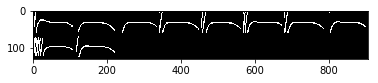

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, parameters = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))

In [10]:
# Corresponding parameters of simulated models -
# (gap, width1, height, radius1, width2).
parameters


1.00000e-05 *
  0.0400  0.1500  0.0850  2.0000  0.0880
  0.0350  0.1550  0.0700  1.8000  0.1000
  0.0300  0.1450  0.0800  1.8000  0.0840
  0.0250  0.1450  0.0800  2.0000  0.0960
  0.0250  0.1500  0.0750  2.0000  0.0920
  0.0350  0.1450  0.0800  2.1000  0.0840
  0.0250  0.1500  0.0800  2.0000  0.0960
  0.0350  0.1450  0.0750  1.9000  0.0880
  0.0300  0.1500  0.0750  2.4000  0.0800
  0.0250  0.1550  0.0850  1.8000  0.0920
[torch.FloatTensor of size 10x5]

In [11]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 5, stride=2),
            nn.MaxPool2d(5, 1),
            nn.Conv2d(3, 5, 3, stride=1),
            nn.MaxPool2d(3, 1),
            nn.ReLU(True),
            nn.Conv2d(5, 2, 3, stride=1),
            nn.MaxPool2d(2, 2)
        )
        self.head = nn.Linear(396, 5)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x.view(x.size(0), -1))

criterion = nn.MSELoss()

# Train

In [12]:
def test_net(net):
    """Function helps to calculate loss on test dataset."""
    test_loss = 0
    for data in test_loader:
        
        inputs, labels = data
        labels = labels * 1e7

        inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.data[0]
    return test_loss

# Training loop

In [13]:
%%time

EPOCH = 10  # Total number of epochs to train.
LR = 0.0001  # Initial learning rate.

net = Net()
optimizer = optim.Adam(net.parameters(), LR)

print_each = 30  # Print training loss every `print_each` iteration.
test_each = 2    # Print testing loss every `test_each` epoch.
reduce_lr = 4    # Reduce `LR` by 2 every `reduce_lr` epoch.

curtimestep = 0
test_steps = []
test_losses = []
train_steps = []
train_losses = []

for epoch in range(EPOCH):  # Loop over the dataset multiple times.
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR
        
        # Get the inputs.
        inputs, parameters = data
        parameters = parameters * 1e7

        # Wrap them in Variable.
        inputs, parameters = Variable(inputs), Variable(parameters)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward -> backward -> optimize.
        outputs = net(inputs)
        loss = criterion(outputs, parameters)
        loss.backward()
        optimizer.step()
        
        # Add loss per element.
        running_loss += loss.data[0] / len(parameters)
        
        curtimestep += 1
        
        # Print statistics.
        if i % print_each == print_each - 1:
            loss_per_element = running_loss / print_each
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss_per_element))
            
            train_losses.append(loss_per_element)
            train_steps.append(curtimestep)
            running_loss = 0.0

    # Calculate loss on test dataset.
    if epoch % test_each == test_each - 1:
        test_loss = test_net(net)
        test_loss /= len(test_dataset)
        print('[%d] Test loss: %.3f' % (epoch + 1, test_loss))
        print('LR: {}'.format(LR))
        
        test_losses.append(test_loss)
        test_steps.append(curtimestep)
    
    # Reduce LR by 2 every `reduce_lr` epoch.
    if epoch % reduce_lr == reduce_lr - 1:
        LR /= 2.

print('Finished Training')

[1,    30] loss: 893.221
[1,    60] loss: 892.250
[1,    90] loss: 885.687
[1,   120] loss: 882.640
[1,   150] loss: 889.854
[1,   180] loss: 851.159
[1,   210] loss: 817.803
[2,    30] loss: 737.177
[2,    60] loss: 667.876
[2,    90] loss: 576.134
[2,   120] loss: 472.879
[2,   150] loss: 363.928
[2,   180] loss: 239.244
[2,   210] loss: 142.912
[2] Test loss: 63.159
LR: 0.0001
[3,    30] loss: 38.046
[3,    60] loss: 18.626
[3,    90] loss: 11.356
[3,   120] loss: 9.556
[3,   150] loss: 7.793
[3,   180] loss: 7.827
[3,   210] loss: 8.046
[4,    30] loss: 7.052
[4,    60] loss: 8.028
[4,    90] loss: 8.728
[4,   120] loss: 8.787
[4,   150] loss: 7.544
[4,   180] loss: 7.732
[4,   210] loss: 7.909
[4] Test loss: 7.911
LR: 0.0001
[5,    30] loss: 6.943
[5,    60] loss: 7.905
[5,    90] loss: 8.605
[5,   120] loss: 8.680
[5,   150] loss: 7.460
[5,   180] loss: 7.651
[5,   210] loss: 7.820
[6,    30] loss: 6.869
[6,    60] loss: 7.838
[6,    90] loss: 8.529
[6,   120] loss: 8.613
[6,   1

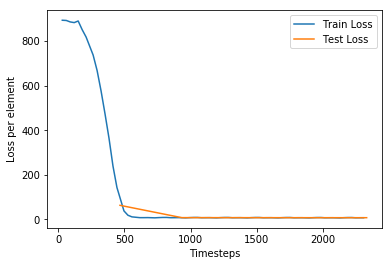

In [14]:
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(test_steps, test_losses, label='Test Loss')
plt.xlabel('Timesteps')
plt.ylabel('Loss per element')
plt.legend()
plt.show()

# Test

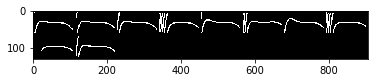

In [15]:
# Get some random testing images.
dataiter = iter(test_loader)
images, parameters = dataiter.next()

# Print images.
imshow(torchvision.utils.make_grid(images))

In [16]:
parameters * 1e7


   3.0000   15.0000    8.0000  180.0000   10.0000
   4.0000   15.5000    7.5000  200.0000    9.6000
   3.5000   15.5000    7.5000  220.0000   10.0000
   2.5000   14.5000    8.0000  240.0000    9.2000
   4.0000   15.5000    8.0000  200.0000    9.6000
   4.0000   15.0000    8.0000  220.0000    8.4000
   4.0000   14.5000    8.5000  190.0000    9.6000
   3.0000   14.5000    7.5000  220.0000    8.4000
   3.5000   15.5000    7.0000  180.0000    8.4000
   3.0000   14.5000    8.5000  210.0000    9.2000
[torch.FloatTensor of size 10x5]

In [17]:
inputs = Variable(images)
outputs = net(inputs)
outputs

Variable containing:
   3.4388   14.7403    7.8929  199.3336   10.2643
   3.6808   14.8384    8.0350  205.2168    9.7051
   3.5863   14.9165    7.9583  202.4897    9.7128
   2.8246   14.8506    7.3698  233.6573    8.4192
   3.8730   14.9021    8.2437  206.3441    9.9175
   4.0964   15.3312    7.9127  214.7819    8.9574
   3.6040   14.7491    8.1898  203.8960    9.6889
   3.1884   14.8638    7.5445  221.7162    8.6519
   3.3074   14.5182    7.4347  184.9650    8.2445
   3.6689   15.2470    7.9955  209.1516    9.2313
[torch.FloatTensor of size 10x5]